# Transfer Learning

Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets training on huge datasets like ImageNet take weeks on multiple GPUs. Instead, most people use a pretrained network either as a fixed feature extractor, or as an initial network to fine tune. In this notebook, you'll be using [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a feature extractor. Below is a diagram of the VGGNet architecture.

<img src="assets/cnnarchitecture.jpg" width=700px>

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but replace the final fully connected layers with our own classifier. This way we can use VGGNet as a feature extractor for our images then easily train a simple classifier on top of that. What we'll do is take the first fully connected layer with 4096 units, including thresholding with ReLUs. We can use those values as a code for each image, then build a classifier on top of those codes.

You can read more about transfer learning from [the CS231n course notes](http://cs231n.github.io/transfer-learning/#tf).

## Pretrained VGGNet

We'll be using a pretrained network from https://github.com/machrisaa/tensorflow-vgg. This code is already included in 'tensorflow_vgg' directory, sdo you don't have to clone it.

This is a really nice implementation of VGGNet, quite easy to work with. The network has already been trained and the parameters are available from this link. **You'll need to clone the repo into the folder containing this notebook.** Then download the parameter file using the next cell.

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

vgg_dir = 'tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file already exists!")

VGG16 Parameters: 553MB [00:29, 18.8MB/s]                               


## Flower power

Here we'll be using VGGNet to classify images of flowers. To get the flower dataset, run the cell below. This dataset comes from the [TensorFlow inception tutorial](https://www.tensorflow.org/tutorials/image_retraining).

In [3]:
import tarfile
from os.path import isfile, isdir

dataset_folder_path = 'car_photos'

with tarfile.open('cars_test.tgz') as tar:
    tar.extractall()
    tar.close()

with tarfile.open('cars_train.tgz') as tar:
    tar.extractall()
    tar.close()

with tarfile.open('car_devkit.tgz') as tar:
    tar.extractall()
    tar.close()

FileNotFoundError: [Errno 2] No such file or directory: 'cars_test.tgz'

## ConvNet Codes

Below, we'll run through all the images in our dataset and get codes for each of them. That is, we'll run the images through the VGGNet convolutional layers and record the values of the first fully connected layer. We can then write these to a file for later when we build our own classifier.

Here we're using the `vgg16` module from `tensorflow_vgg`. The network takes images of size $224 \times 224 \times 3$ as input. Then it has 5 sets of convolutional layers. The network implemented here has this structure (copied from [the source code](https://github.com/machrisaa/tensorflow-vgg/blob/master/vgg16.py)):

```
self.conv1_1 = self.conv_layer(bgr, "conv1_1")
self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
self.pool1 = self.max_pool(self.conv1_2, 'pool1')

self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
self.pool2 = self.max_pool(self.conv2_2, 'pool2')

self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
self.pool3 = self.max_pool(self.conv3_3, 'pool3')

self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
self.pool4 = self.max_pool(self.conv4_3, 'pool4')

self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
self.pool5 = self.max_pool(self.conv5_3, 'pool5')

self.fc6 = self.fc_layer(self.pool5, "fc6")
self.relu6 = tf.nn.relu(self.fc6)
```

So what we want are the values of the first fully connected layer, after being ReLUd (`self.relu6`). To build the network, we use

```
with tf.Session() as sess:
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)
```

This creates the `vgg` object, then builds the graph with `vgg.build(input_)`. Then to get the values from the layer,

```
feed_dict = {input_: images}
codes = sess.run(vgg.relu6, feed_dict=feed_dict)
```

In [2]:
import os

import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

In [3]:
# TODO: modify this to look at CSV and pull car models as types

#read in classes
car_models = pd.read_csv("/cars/cars_meta.csv")

classes = [model for model in car_models['Model']]


In [180]:
# to build up dataset, we'll first read in the labels of the datasets into python DF

train_data_labels = pd.read_csv("/cars/cars_train_annos.csv")
test_data_labels = pd.read_csv("/cars/cars_test_annos.csv")

print(train_data_labels.shape)

#print(train_data_labels.loc[train_data_labels['fname'] == '03439.jpg']['class'])
#drop_value = []
#file = "03439.jpg"
#drop_value.append(train_data_labels[train_data_labels['fname'] == file].index[0])
#drop_value.append(train_data_labels[train_data_labels['fname'] == "05177.jpg"].index[0])
#train_data_labels = train_data_labels.drop(drop_value)
#print(train_data_labels.shape)

#print(train_data_labels.loc[train_data_labels['fname'] ==  '03439.jpg']['class'])
#print(np.asscalar(train_data_labels.loc[train_data_labels['fname'] ==  '00001.jpg']['class']))
labels = []
labels.append(np.asscalar(train_data_labels.loc[train_data_labels['fname'] ==  '00001.jpg']['class']))
print(labels)

(8144, 6)
[14]


In [200]:
files = os.listdir("/cars/cars_train")
for ii, file in enumerate(files, 1):
    # Add images to the current batch
    # utils.load_image crops the input images for us, from the center
    img = utils.load_image(os.path.join("/cars/cars_train", file))
    #check to make sure image is proper size
    if(img.size == 150528):
        print(file)
        print(np.asscalar(train_data_labels.loc[train_data_labels['fname'] == file]['class']))


03884.jpg
183
03860.jpg
39
05785.jpg
169
04084.jpg
177
05677.jpg
166
06796.jpg
90
06570.jpg
13
04993.jpg
75
07499.jpg
60
07032.jpg
110
02516.jpg
36
06848.jpg
74
04015.jpg
81
03175.jpg
43
07954.jpg
56
06568.jpg
17
06732.jpg
147
00022.jpg
36
05846.jpg
112
04475.jpg
25
03973.jpg
163
04469.jpg
31
05324.jpg
4
06015.jpg
156
00187.jpg
160
01814.jpg
194
01341.jpg
73
04607.jpg
106
06908.jpg
146
04752.jpg
100
06725.jpg
145
02147.jpg
178
02438.jpg
7
01137.jpg
90
00752.jpg
168
01279.jpg
131
02192.jpg
145
06641.jpg
153
07017.jpg
51
06967.jpg
113
01152.jpg
78
07632.jpg
143
00798.jpg
27
06177.jpg
145
02020.jpg
101
00357.jpg
39
00463.jpg
89
00600.jpg
20
05833.jpg
61
01144.jpg
190
01950.jpg
163
07072.jpg
127
02803.jpg
150
06567.jpg
59
01235.jpg
156
06521.jpg
103
02664.jpg
101
02662.jpg
82
07006.jpg
188
06675.jpg
10
02161.jpg
149
08039.jpg
147
06713.jpg
46
04579.jpg
127
04532.jpg
142


KeyboardInterrupt: 

In [163]:
# Set the batch size higher if you can fit in in your GPU memory
batch_size = 10
codes_list = []
labels = []
batch = []

# keep a list of labels to drop for images that are too small
drop_values = []

codes = None


#reset old graph
tf.reset_default_graph()

# note, we'll keep the classes as integer values 
with tf.Session() as sess:
    
    # TODO: Build the vgg network here
    with tf.Session() as sess:
        vgg = vgg16.Vgg16()
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        with tf.name_scope("content_vgg"):
                vgg.build(input_)

    print("Starting to import images")
    files = os.listdir("/cars/cars_train")
    for ii, file in enumerate(files, 1):
        # Add images to the current batch
        # utils.load_image crops the input images for us, from the center
        img = utils.load_image(os.path.join("/cars/cars_train", file))
        #check to make sure image is proper size
        if(img.size == 150528):
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(np.asscalar(train_data_labels.loc[train_data_labels['fname'] == file]['class']))

        else:
            print(file)
            drop_values.append(train_data_labels[train_data_labels['fname'] == file].index[0])
        

        # Running the batch through the network to get the codes
        if ii % batch_size == 0 or ii == len(files):

            # Image batch to pass to VGG network
            images = np.concatenate(batch)

            # TODO: Get the values from the relu6 layer of the VGG network
            feed_dict = {input_: images}
            codes_batch = sess.run(vgg.relu6, feed_dict = feed_dict )

            # Here I'm building an array of the codes
            if codes is None:
                codes = codes_batch
            else:
                codes = np.concatenate((codes, codes_batch))

            # Reset to start building the next batch
            batch = []
            print('{} images processed'.format(ii))
            
    print(drop_values)
    print(len(labels))
    train_data_labels = train_data_labels.drop(drop_values)

/output/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Starting to import images
10 images processed
20 images processed
30 images processed
40 images processed
50 images processed
60 images processed
70 images processed
80 images processed
90 images processed
100 images processed
110 images processed
120 images processed
130 images processed
140 images processed
150 images processed
160 images processed
170 images processed
180 images processed
190 images processed
200 images processed
210 images processed
220 images processed
230 images processed
240 images processed
250 images processed
260 images processed
270 images processed
280 images processed
290 images processed
300 images processed
310 images processed
320 images processed
330 images processed
340 images processed
350 images processed
360 images processed
370 images processed
380 images processed
390 images processed
400 images processed
410 images processed
420 images processed
430 ima

3690 images processed
3700 images processed
3710 images processed
3720 images processed
3730 images processed
3740 images processed
3750 images processed
3760 images processed
3770 images processed
3780 images processed
3790 images processed
3800 images processed
3810 images processed
3820 images processed
3830 images processed
3840 images processed
3850 images processed
3860 images processed
3870 images processed
3880 images processed
3890 images processed
3900 images processed
3910 images processed
3920 images processed
3930 images processed
3940 images processed
3950 images processed
3960 images processed
3970 images processed
3980 images processed
3990 images processed
4000 images processed
4010 images processed
4020 images processed
4030 images processed
4040 images processed
4050 images processed
4060 images processed
4070 images processed
4080 images processed
4090 images processed
4100 images processed
4110 images processed
4120 images processed
4130 images processed
4140 image

7380 images processed
7390 images processed
7400 images processed
7410 images processed
7420 images processed
7430 images processed
02176.jpg
7440 images processed
7450 images processed
7460 images processed
7470 images processed
7480 images processed
7490 images processed
7500 images processed
7510 images processed
7520 images processed
7530 images processed
7540 images processed
7550 images processed
7560 images processed
7570 images processed
7580 images processed
7590 images processed
7600 images processed
7610 images processed
7620 images processed
7630 images processed
7640 images processed
7650 images processed
7660 images processed
7670 images processed
7680 images processed
7690 images processed
7700 images processed
7710 images processed
7720 images processed
7730 images processed
7740 images processed
7750 images processed
7760 images processed
7770 images processed
7780 images processed
7790 images processed
7800 images processed
7810 images processed
7820 images processed


Below I'm running images through the VGG network in batches.

> **Exercise:** Below, build the VGG network. Also get the codes from the first fully connected layer (make sure you get the ReLUd values).

print(len(labels)
8126

In [164]:
# write codes to file
with open('codes', 'w') as f:
    codes.tofile(f)
    
# write labels to file
import csv
with open('labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

## Building the Classifier

Now that we have codes for all the images, we can build a simple classifier on top of them. The codes behave just like normal input into a simple neural network. Below I'm going to have you do most of the work.

In [185]:
# read codes and labels from file
import csv

with open('labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))

### Data prep

As usual, now we need to one-hot encode our labels and create validation/test sets. First up, creating our labels!

> **Exercise:** From scikit-learn, use [LabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) to create one-hot encoded vectors from the labels. 

In [198]:
# transform labels into appropriate classes
car_lookup = car_models.iloc[[14],[0]]

#new_labels = [ car_models.iloc[[int(label)], [0]].values[0] for label in labels]
new_labels = []
for label in labels:
    new_label = int(label)
    car_lookup = car_models.iloc[[new_label-1], [0]].values[0]
    new_labels.append(car_lookup[0])



1
Suzuki SX4 Hatchback 2012


In [202]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(classes)

labels_vecs = lb.transform(new_labels)


Now you'll want to create your training, validation, and test sets. An important thing to note here is that our labels and data aren't randomized yet. We'll want to shuffle our data so the validation and test sets contain data from all classes. Otherwise, you could end up with testing sets that are all one class. Typically, you'll also want to make sure that each smaller set has the same the distribution of classes as it is for the whole data set. The easiest way to accomplish both these goals is to use [`StratifiedShuffleSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) from scikit-learn.

You can create the splitter like so:
```
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
```
Then split the data with 
```
splitter = ss.split(x, y)
```

`ss.split` returns a generator of indices. You can pass the indices into the arrays to get the split sets. The fact that it's a generator means you either need to iterate over it, or use `next(splitter)` to get the indices. Be sure to read the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) and the [user guide](http://scikit-learn.org/stable/modules/cross_validation.html#random-permutations-cross-validation-a-k-a-shuffle-split).

> **Exercise:** Use StratifiedShuffleSplit to split the codes and labels into training, validation, and test sets.

In [203]:
from sklearn.model_selection import StratifiedShuffleSplit
ss = StratifiedShuffleSplit(n_splits= 1, test_size = 0.2)
splitter = ss.split(codes, labels)

train_idx, val_idx = next(ss.split(codes, labels))
val_test_split = int(len(val_idx) / 2)
val_idx, test_idx = val_idx[:val_test_split], val_idx[val_test_split:]
    
train_x, train_y = codes[train_idx], labels_vecs[train_idx]
val_x, val_y = codes[val_idx], labels_vecs[val_idx]
test_x, test_y =  codes[test_idx], labels_vecs[test_idx]

In [204]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)

Train shapes (x, y): (6500, 4096) (6500, 196)
Validation shapes (x, y): (813, 4096) (813, 196)
Test shapes (x, y): (813, 4096) (813, 196)


If you did it right, you should see these sizes for the training sets:

```
Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)
```

### Classifier layers

Once you have the convolutional codes, you just need to build a classfier from some fully connected layers. You use the codes as the inputs and the image labels as targets. Otherwise the classifier is a typical neural network.

> **Exercise:** With the codes and labels loaded, build the classifier. Consider the codes as your inputs, each of them are 4096D vectors. You'll want to use a hidden layer and an output layer as your classifier. Remember that the output layer needs to have one unit for each class and a softmax activation function. Use the cross entropy to calculate the cost.

In [300]:
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]])
keep_prob = tf.placeholder(tf.float32)


fc = tf.contrib.layers.fully_connected(inputs_, 256)
drop_out_layer = tf.nn.dropout(fc, keep_prob)

logits = tf.contrib.layers.fully_connected(drop_out_layer, labels_vecs.shape[1], activation_fn=None)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer().minimize(cost)

predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

### Batches!

Here is just a simple way to do batches. I've written it so that it includes all the data. Sometimes you'll throw out some data at the end to make sure you have full batches. Here I just extend the last batch to include the remaining data.

In [296]:
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

### Training

Here, we'll train the network.

> **Exercise:** So far we've been providing the training code for you. Here, I'm going to give you a bit more of a challenge and have you write the code to train the network. Of course, you'll be able to see my solution if you need help. Use the `get_batches` function I wrote before to get your batches like `for x, y in get_batches(train_x, train_y)`. Or write your own!

In [320]:
epochs = 50
iteration = 0
saver = tf.train.Saver()
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for x, y in get_batches(train_x, train_y):
            feed = {inputs_: x,
                    labels_: y,
                    keep_prob: 1.0}
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            #print("Epoch: {}/{}".format(e, epochs),
                 # "Iteration: {}".format(iteration),
                 # "Training loss: {:.4f}".format(loss))
            iteration += 1
            
            if iteration % 5 == 0:
                feed = {inputs_: val_x,
                        labels_: val_y,
                        keep_prob: 1.0}
                val_acc = sess.run(accuracy, feed_dict=feed)
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Validation Acc: {:.4f}".format(val_acc))
    saver.save(sess, "checkpoints/flowers.ckpt")

Epoch: 0/50 Iteration: 5 Validation Acc: 0.0160
Epoch: 0/50 Iteration: 10 Validation Acc: 0.0185
Epoch: 1/50 Iteration: 15 Validation Acc: 0.0221
Epoch: 1/50 Iteration: 20 Validation Acc: 0.0283
Epoch: 2/50 Iteration: 25 Validation Acc: 0.0492
Epoch: 2/50 Iteration: 30 Validation Acc: 0.0467
Epoch: 3/50 Iteration: 35 Validation Acc: 0.0652
Epoch: 3/50 Iteration: 40 Validation Acc: 0.0615
Epoch: 4/50 Iteration: 45 Validation Acc: 0.0726
Epoch: 4/50 Iteration: 50 Validation Acc: 0.0763
Epoch: 5/50 Iteration: 55 Validation Acc: 0.0812
Epoch: 5/50 Iteration: 60 Validation Acc: 0.1033
Epoch: 6/50 Iteration: 65 Validation Acc: 0.1242
Epoch: 6/50 Iteration: 70 Validation Acc: 0.1341
Epoch: 7/50 Iteration: 75 Validation Acc: 0.1476
Epoch: 7/50 Iteration: 80 Validation Acc: 0.1562
Epoch: 8/50 Iteration: 85 Validation Acc: 0.1562
Epoch: 8/50 Iteration: 90 Validation Acc: 0.1710
Epoch: 9/50 Iteration: 95 Validation Acc: 0.1833
Epoch: 9/50 Iteration: 100 Validation Acc: 0.1808
Epoch: 10/50 Iterati

### Testing

Below you see the test accuracy. You can also see the predictions returned for images.

In [321]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y,
            keep_prob: 1.0}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt
Test accuracy: 0.2977


In [322]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

Below, feel free to choose images and see how the trained classifier predicts the flowers in them.

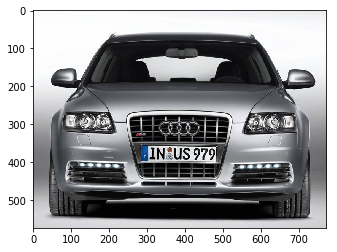

In [323]:
test_img_path = '/cars/cars_test/00110.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [324]:
# Run this cell if you don't have a vgg graph built
if 'vgg' in globals():
    print('"vgg" object already exists.  Will not create again.')
else:
    #create vgg
    with tf.Session() as sess:
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        vgg = vgg16.Vgg16()
        vgg.build(input_)

"vgg" object already exists.  Will not create again.


In [325]:
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))

    feed_dict = {input_: img, keep_prob: 1.0}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code, keep_prob: 1.0}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt


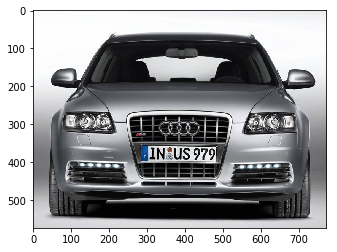

In [326]:
plt.imshow(test_img)

In [330]:
#print(prediction.shape)
#print(lb.classes_.shape)
#plt.barh(np.arange(196), prediction)
#_ = plt.yticks(np.arange(196), lb.classes_)

#print(prediction.flatten())
class_score = list(zip(list(lb.classes_),list(prediction.flatten())))
class_score.sort(key=lambda x: -x[1])
print(class_score[:5])


#for pred, cls in zip(prediction, lb.classes_):
#    print("Predicted class {} with score {}".format(cls, pred))

[('Audi S6 Sedan 2011', 0.68621212), ('Audi S4 Sedan 2007', 0.1880848), ('Jeep Compass SUV 2012', 0.038749304), ('Dodge Durango SUV 2012', 0.026399238), ('Audi S4 Sedan 2012', 0.013928952)]
